# Pairtools walkthrough

Welcome to the pairtools walkthrough. 

Pairtools is a tool for extraction of pairwise contacts out of sequencing chromosomes conformation capture data, such as Hi-C, Micro-C or MC-3C.
Pairtools is used for obtaining .cool files by [distiller](https://github.com/open2c/distiller-nf/blob/master/distiller.nf), and has many more applications (see single-cell walkthrough or phasing walkthrough). 

Here, we will cover the basic steps from raw reads to .cool file with binned contacts.

Outline:

- [Download raw data](#Download-raw-data)

- [Install reference genome](#Install-reference-genome)

- [Map data with bwa mem](#Map-data-with-bwa-mem)

- [Extract contacts](#Contacts-extraction)

- [MultiQC]( #MultiQC )

- [Load pairs to cooler](#Load-pairs-to-cooler)

- [Visualize cooler](#Visualize-cooler)

### Download raw data

"Raw" data, or .fastq files are generated by sequencing facilities or can be taken from public databases, such as SRA. We will take a sample from Rao et at al. 2017, human datasets.
To reduce computateion time, take 5 mln reads instead of full sample:

In [ ]:
! fastq-dump SRR13849430 --gzip --split-spot --split-3 --minSpotId 0 --maxSpotId 5000000

In [1]:
! ls SRR13849430*.fastq.gz

SRR13849430_1.fastq.gz	SRR13849430_2.fastq.gz


In [2]:
%%bash
gzip -dc SRR13849430_1.fastq.gz | head -n 8

@SRR13849430.1 1 length=150
NTCTCAGCCTTTATAAGATAGAAGAGAGTTGGGACCTTGCTCTAAATTCTGCTTTAGCAAGGGACTTTTGTACCTGCTTTCTTCCTTTATCCAGATCTAAAAATAGTTTATATGCTGACAACTCCCTGATGTTATTCTTTGTAGTATTTG
+SRR13849430.1 1 length=150
#AAFFJJJJJJJJJJJAJAJJJJFJJJAFFFFFFA7A-FJ7JJJ-AJAJJF-<-JJFFJ7FJJF7FJJFJJ<JFAF<JJJJAJJJJA-AFJ-FJ-FF<7-A-7A-FFF<J-FJJJ<F7)A-F--7))))--77--7------A---7-7-
@SRR13849430.2 2 length=150
NAAAAGGTTTATCTCTGTGAGATGAAGCCACATAAAACCAAGCAGTTTCACAGAAACTTGTTTGTAGATTTTAAATCCGCACATCACAAAGCCATTTCACAGACAGCTTCTTTCTACTTTTTATCTGCGGCCCTTCCGTATTCCCGCATA
+SRR13849430.2 2 length=150
#AAFAJJFJJJJFAAFJA<JJJFJJFJJJJJFFJ-FF<FFJJJJJJ7AFFF<FJJ-<-F7<7<A-AF7AJAJ-A-7FF7JJJFJJFJJFFFFAJFJJ7-7-A-F--777FJFJF7---AAAF<AAA--))--))-<))-------)))7-


We next map the sequencing data to the reference genome.

### Install reference genome

Although you may download and build bwa index for any genome manually, `genompy` can do that for you automatically: 

In [ ]:
# Activate bwa plugin for genomepy:
! genomepy plugin enable bwa

In [ ]:
# Install hg38 genome by genomepy, it might take some time to compile the bwa index for hg38:
! genomepy install hg38

In [2]:
# Check the location of the genome:
! ls ~/.local/share/genomes/hg38/

bwa-mem2	       hg38_DpnII.bed  hg38.fa	    hg38.fa.sizes  index
hg38.blacklist.bed.gz  hg38.DpnII.bed  hg38.fa.fai  hg38.gaps.bed  README.txt


### Map data with bwa mem

Note that you may use [bwa mem2](https://github.com/bwa-mem2/bwa-mem2), which is x2 times faster. 
It [proved to produce](https://github.com/open2c/pairtools/discussions/118) results very similar to bwa mem.

In [ ]:
# Map test data:
! bwa mem -t 5 -SP ~/.local/share/genomes/hg38/index/bwa/hg38.fa SRR13849430_1.fastq.gz SRR13849430_2.fastq.gz > test.bam

After mapping, you have .sam/.bam alignment file, which cannot be interpreted as pairs directly. You need to extract contacts from it:

In [2]:
%%bash 
samtools view test.bam | head -n 4

SRR13849430.1	121	chr12	78795720	60	53S97M	=	78795720	0	CAAATACTACAAAGAATAACATCAGGGAGTTGTCAGCATATAAACTATTTTTAGATCTGGATAAAGGAAGAAAGCAGGTACAAAAGTCCCTTGCTAAAGCAGAATTTAGAGCAAGGTCCCAACTCTCTTCTATCTTATAAAGGCTGAGAN	-7-7---A------7--77--))))7--F-A)7F<JJJF-J<FFF-A7-A-7<FF-JF-JFA-AJJJJAJJJJ<FAFJ<JJFJJF7FJJF7JFFJJ-<-FJJAJA-JJJ7JF-A7AFFFFFFAJJJFJJJJAJAJJJJJJJJJJJFFAA#	NM:i:1	MD:Z:96G0	MQ:i:0	AS:i:96	XS:i:21
SRR13849430.1	181	chr12	78795720	0	*	=	78795720	0	TTATATGCTGACGTCGTCCATTGTTGATTCTTTGTGGTCTGTGTTCCCTCTGAAGCTCTCTGTACTTGTATATACAATTAGGCACCAACAATTCAACATGGGTAGTTATTATACTGCTAAAGCGACCCCAGAGCGAACCGGGCTACCTTN	---7---7-7)))-7---7-----7-7<---7-)<)<-----)-)<77--7---)7-<7-7----A-F<<-AF7-A777--77-7-----7--<--7-F777-A7-7---<7--7<7-<--77-77--77--7-7A---7-7---FF<A#	MC:Z:53S97M	MQ:i:60	AS:i:0	XS:i:0
SRR13849430.2	73	chr8	43879758	60	75M75S	=	43879758	0	NAAAAGGTTTATCTCTGTGAGATGAAGCCACATAAAACCAAGCAGTTTCACAGAAACTTGTTTGTAGATTTTAAATCCGCACATCACAAAGCCATTTCACAGACAGCTTCTTTCTACTTTTTATCTGCGGCCCTTCCGTATTCCCGCATA	#AAFAJJFJJJ

### Contacts extraction

Challenges of contacts extraction solved by `pairtools`:

- multiple walks in each Hi-C read

- alignments spaced by short genomic distance may be reported as single alignment with a gap by bwa

- PCR and optical duplicates

#### pairtools parse

The next step is to parse .sam/.bam into pairs. `pairtools parse` automatically detect the file format.

Full parse documentation: https://github.com/open2c/pairtools/blob/master/doc/parsing.rst


In [ ]:
%%bash
pairtools parse -o test.pairs.gz -c ~/.local/share/genomes/hg38/hg38.fa.sizes \
  --drop-sam --drop-seq --output-stats test.stats \
  --assembly hg38 --no-flip \
  --add-columns mapq \
  --walks-policy mask \
  test.bam

Parse will result in .pairs file. .pairs is a simple tabular format for storing DNA contacts detected in a Hi-C experiment. The detailed [.pairs specification](https://github.com/4dn-dcic/pairix/blob/master/pairs_format_specification.md) is defined by the 4DN Consortium.

In [3]:
%%bash
# Header
gzip -dc test.pairs.gz | head -n 5

## pairs format v1.0.0
#shape: whole matrix
#genome_assembly: hg38
#chromsize: chr1 248956422
#chromsize: chr10 133797422


In [4]:
%%bash
# Last lines of the header contain the list of columns:
gzip -dc test.pairs.gz | grep "#" | tail -n 5

#samheader: @SQ	SN:chrY_KI270740v1_random	LN:37240
#samheader: @HD	VN:1.5	SO:unsorted	GO:query
#samheader: @PG	ID:bwa	PN:bwa	VN:0.7.18-r1243-dirty	CL:bwa mem -t 5 -SP /home/agalicina/.local/share/genomes/hg38/index/bwa/hg38.fa SRR13849430_1.fastq.gz SRR13849430_2.fastq.gz
#samheader: @PG	ID:pairtools_parse	PN:pairtools_parse	CL:/home/agalicina/anaconda3/envs/test/bin/pairtools parse -o test.pairs.gz -c /home/agalicina/.local/share/genomes/hg38/hg38.fa.sizes --drop-sam --drop-seq --output-stats test.stats --assembly hg38 --no-flip --add-columns mapq --walks-policy mask test.bam	PP:bwa	VN:1.1.3
#columns: readID chrom1 pos1 chrom2 pos2 strand1 strand2 pair_type mapq1 mapq2


In [5]:
%%bash 
# Body of the .pairs file
gzip -dc test.pairs.gz | grep -v "#" | head -n 5

SRR13849430.1	chr12	78795816	!	0	-	-	UN	60	0
SRR13849430.2	!	0	!	0	-	-	WW	60	0
SRR13849430.3	chr2	72005391	!	0	+	-	UN	60	0
SRR13849430.4	chr2	20530788	!	0	+	-	UN	60	0
SRR13849430.5	!	0	!	0	-	-	WW	0	0


#### pairtools sort

After parsing each pair is listed in the orderthat it appeared in the reads file. 
Sorting makes it more organised, and also helps to perform deduplication which cannot work on non-sorted files. 

In [ ]:
%%bash
pairtools sort --nproc 5 -o test.sorted.pairs.gz test.pairs.gz

#### pairtools dedup


In [ ]:
%%bash
pairtools dedup \
    --max-mismatch 3 \
    --mark-dups \
    --output \
        >( pairtools split \
            --output-pairs test.nodups.pairs.gz \
            --output-sam test.nodups.bam \
         ) \
    --output-unmapped \
        >( pairtools split \
            --output-pairs test.unmapped.pairs.gz \
            --output-sam test.unmapped.bam \
         ) \
    --output-dups \
        >( pairtools split \
            --output-pairs test.dups.pairs.gz \
            --output-sam test.dups.bam \
         ) \
    --output-stats test.dedup.stats \
    test.sorted.pairs.gz

In [6]:
%%bash
# Unique pairs:
gzip -dc test.nodups.pairs.gz | grep -v "#" | head -n 10

SRR13849430.4544778	chr1	136880	chr1	134881	+	+	UR	28	3
SRR13849430.4112679	chr1	136992	chr1	136650	-	+	UU	17	12
SRR13849430.1113517	chr1	599102	chr1	599228	+	-	UU	22	22
SRR13849430.1262300	chr1	656693	chr1	886234	+	-	UU	5	60
SRR13849430.2778343	chr1	760774	chr1	808155	-	+	UU	6	21
SRR13849430.3231567	chr1	777267	chr1	35948382	+	-	UU	32	60
SRR13849430.4836373	chr1	778257	chr1	777890	-	+	UU	8	48
SRR13849430.1256119	chr1	785664	chr1	954301	+	+	UU	60	60
SRR13849430.2390636	chr1	788677	chr1	22439216	-	+	UU	8	60
SRR13849430.3622660	chr1	788734	chr1	822206	+	-	RU	60	26


In [7]:
%%bash
# Only duplicated  pairs:
gzip -dc test.dups.pairs.gz | grep -v "#" | head -n 10

SRR13849430.2781007	chr1	760774	chr1	808155	-	+	DD	6	20
SRR13849430.1103881	chr1	855594	chr1	856474	+	-	DD	42	47
SRR13849430.3637378	chr1	860367	chr1	863893	-	-	DD	50	42
SRR13849430.3708228	chr1	860367	chr1	863893	-	-	DD	50	43
SRR13849430.1681017	chr1	904370	chr1	952493	-	-	DD	60	60
SRR13849430.4712708	chr1	912376	chr1	913168	-	-	DD	60	60
SRR13849430.169202	chr1	920729	chr1	929007	-	+	DD	60	60
SRR13849430.1735365	chr1	929632	chr1	925420	+	+	DD	60	60
SRR13849430.1743119	chr1	929632	chr1	925420	+	+	DD	60	60
SRR13849430.1755818	chr1	929632	chr1	925420	+	+	DD	60	60


#### pairtools select

Sometimes you may need certain types of pairs based on their properties, such as mapq, pair type, distance or orientation. 
For all these manipulations, there is `pairtools select` which requires a file and pythonic condition as an input:

In [ ]:
%%bash 
pairtools select "mapq1>0 and mapq2>0" test.nodups.pairs.gz -o test.nodups.UU.pairs.gz

#### pairtools stats

Describe the types fo distance properties of pairs: 

In [ ]:
%%bash
pairtools stats test.pairs.gz -o test.stats

### MultiQC

To make a nice HTML with pairs stats, install Open2C version of multiQC from:  https://github.com/open2c/MultiQC

In [ ]:
%%bash
multiqc test.stats

In [10]:
from IPython.display import IFrame

IFrame(src='./multiqc_report.html', width=1200, height=700)

### Load pairs to cooler
Finally, when you obtained a list of appropriate pairs, you may create coolers with it: 

In [ ]:
%%bash
cooler cload pairs \
    -c1 2 -p1 3 -c2 4 -p2 5 \
    --assembly hg38 \
    ~/.local/share/genomes/hg38/hg38.fa.sizes:1000000 \
    test.nodups.UU.pairs.gz \
    test.hg38.1000000.cool

In [ ]:
%%bash
cooler zoomify \
    --nproc 5 \
    --out test.hg38.1000000.mcool \
    --resolutions 1000000,2000000 \
    --balance \
    test.hg38.1000000.cool

### Visualize cooler

Based on [open2c vis example](https://github.com/open2c/open2c_examples/blob/master/viz.ipynb)

In [11]:
import cooler
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import cooltools.lib.plotting
from matplotlib.colors import LogNorm
import seaborn as sns
import bioframe
import numpy as np

In [12]:
file = "test.hg38.1000000.mcool::/resolutions/1000000"

In [13]:
clr = cooler.Cooler(file)

In [14]:
# Define chromosome starts
chromstarts = []
for i in clr.chromnames:
        chromstarts.append(clr.extent(i)[0])

In [15]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [20]:
# Define the bounds of the continuous fragment of whole-genome interaction map
chrom_start, chrom_end = clr.chromnames.index('chr10'), clr.chromnames.index('chr11')
start, end = chromstarts[chrom_start], chromstarts[chrom_end]

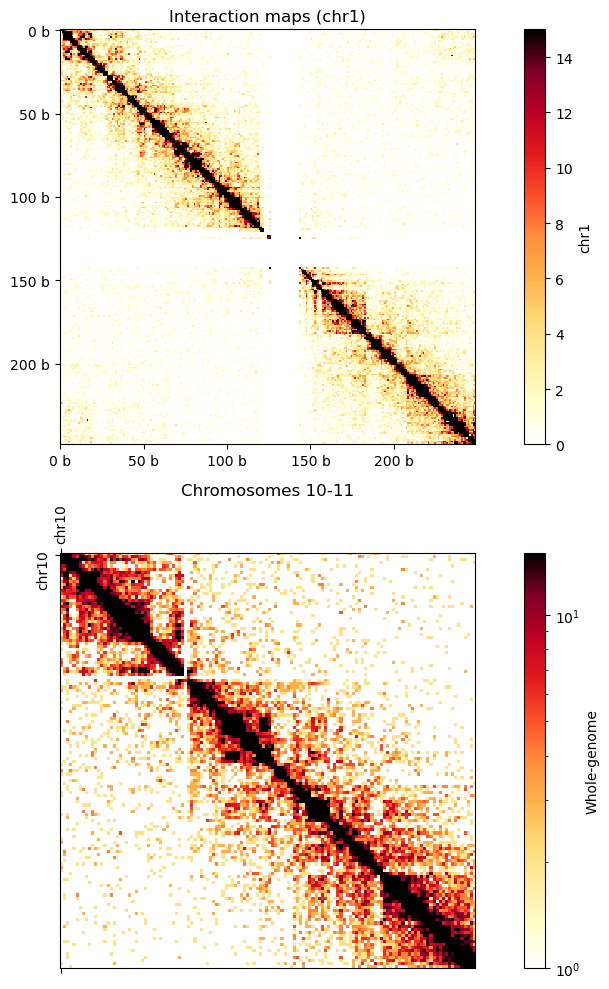

In [21]:
vmax = 15
norm = LogNorm(vmin=1, vmax=vmax)

f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2, 
    ncols=1,
    sharex=False, sharey=False)

ax = axs[0]
ax.set_title('Interaction maps (chr1)')
im = ax.matshow(clr.matrix(balance=False).fetch('chr1'), vmax=vmax, cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='chr1');

ax = axs[1]
ax.set_title('Chromosomes 10-11')
im = ax.matshow(clr.matrix(balance=False)[start:end, start:end], norm=norm, cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='Whole-genome');
ax.set_xticks(np.array(chromstarts[chrom_start:chrom_end])-start, clr.chromnames[chrom_start:chrom_end], rotation=90);
ax.set_yticks(np.array(chromstarts[chrom_start:chrom_end])-start, clr.chromnames[chrom_start:chrom_end], rotation=90);

format_ticks(axs[0], rotate=False)

plt.tight_layout()